Author detection or author attribution is an important field in NLP that enables us
to verify the authorship of papers or novels and allows us to identify anonymous
authors.  


In this first try to merge and understand what people have done at the works below. Also this notebook is designed to be an answer for the following Kaggle challenge


* http://cs224d.stanford.edu/reports/ZhouWang.pdf
* http://cs224d.stanford.edu/reports/MackeStephen.pdf
* http://cs224d.stanford.edu/reports/RhodesDylan.pdf
* http://cs224d.stanford.edu/reports/YaoLeon.pdf
* https://www.kaggle.com/christopher22/stylometry-identify-authors-by-sentence-structure#
* https://www.kaggle.com/drissaitlabsir27/author-identification-spacy-rnn#

* https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author#
* https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines#
* https://www.kaggle.com/nzw0301/simple-keras-fasttext-val-loss-0-31#
* https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras#
* https://www.kaggle.com/snapcrack/all-the-news/version/3/kernels


## DATASET EXPLORATION 

In [2]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split

A quick look to the data 

In [3]:
train = pd.read_csv('../Data/author_identification/train.csv')
# train['text'] = train.content
# train = train[['id','text', 'author']]
test = pd.read_csv('../Data/author_identification/test.csv')

# sample = pd.read_csv('../Data/author_identification/sample_submission.csv')

Let's first see the data

In [4]:
train = train.dropna(subset=['author'])

In [5]:
test.head()

,id,text,author
0,id19764,Herbert West needed fresh bodies because his l...,HPL
1,id11411,Now the net work was not permanently fastened ...,EAP
2,id08075,"It was not that the sounds were hideous, for t...",HPL
3,id00764,"I was rich and young, and had a guardian appoi...",MWS
4,id01577,"Wilbur's growth was indeed phenomenal, for wit...",HPL


We use the LabelEncoder from scikit-learn to convert text labels to integers, 0, 1 2

In [6]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)

Before going further it is important that we split the data into training and validation sets. We can do it using train_test_split from the model_selection module of scikit-learn.

In [7]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)



So let's see first the number of training instance and validation instance

In [8]:
print(len(xtrain))
print(len(xvalid))

12764
1419


#### Visualizations

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


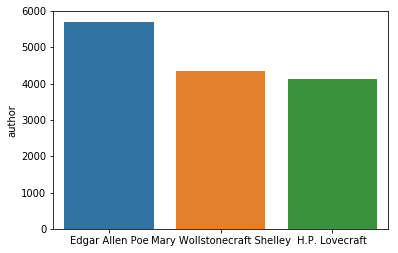

In [10]:
sns.set_style()
sns.barplot(x=['Edgar Allen Poe', 'Mary Wollstonecraft Shelley', 'H.P. Lovecraft'], y = train.author.value_counts())
# train.author.value_counts()

Edgar Allen Poe is the most frequently occuring author in the training dataset with 7900 occurances. Then it's Mary Wollstonecraft Shelley followed by H.P. Lovecraft with 6044 and 5635 occurances respectively. While there are more occurances of EAP than HPL and MWS there is still a good amount of data labeled with HPL and MWS so the small data imbalance shouldn't impact learning too much.

### Wordclouds

TODO See: https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras#

## MODELS

First let's create the function to find the accuracy

In [11]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

from sklearn.metrics import accuracy_score


#### Model 1 - TF - IDF + Logistic Regression

Our very first model is a simple TF-IDF (Term Frequency - Inverse Document Frequency) followed by a simple Logistic Regression.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [13]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=0,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(xtrain)
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [21]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
y_pred = np.array([f.argmax() for f in predictions])
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print("Accuracy : %0.3f" %accuracy_score(yvalid, y_pred))


logloss: 0.647 
Accuracy : 0.791


#### Model 2 TF  + Logistic Regression

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [23]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [24]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)
y_pred = np.array([f.argmax() for f in predictions])
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print("Accuracy : %0.3f" %accuracy_score(yvalid, y_pred))



logloss: 0.539 
Accuracy : 0.779


### TF - IDF + Naive Bayes

In [25]:
from sklearn.naive_bayes import MultinomialNB

In [28]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
y_pred = np.array([f.argmax() for f in predictions])
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print("Accuracy : %0.3f" %accuracy_score(yvalid, y_pred))


logloss: 0.607 
Accuracy : 0.803


### TF  + Naive Bayes

In [29]:
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)
y_pred = np.array([f.argmax() for f in predictions])
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print("Accuracy : %0.3f" %accuracy_score(yvalid, y_pred))

logloss: 0.468 
Accuracy : 0.820


### TF-IDF  + XGBoost

In [31]:
import xgboost as xgb

In [32]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())
y_pred = np.array([f.argmax() for f in predictions])

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print("Accuracy : %0.3f" %accuracy_score(yvalid, y_pred))

logloss: 0.768 
Accuracy : 0.674


### GRID Parameter Search for Models Till Now

So let's choose 

In [33]:
from sklearn import metrics, pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV

In [34]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

In [35]:


# Initialize SVD
svd = TruncatedSVD()
    
# Initialize the standard scaler 
scl = preprocessing.StandardScaler()

# We will use logistic regression here..
lr_model = LogisticRegression()

# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])


In [36]:
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}


In [37]:
# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] lr__C=0.1, lr__penalty=l1, svd__n_components=120 ................
[CV] lr__C=0.1, lr__penalty=l1, svd__n_components=120 ................
[CV] lr__C=0.1, lr__penalty=l1, svd__n_components=180 ................
[CV] lr__C=0.1, lr__penalty=l1, svd__n_components=180 ................
[CV] lr__C=0.1, lr__penalty=l2, svd__n_components=120 ................
[CV] lr__C=0.1, lr__penalty=l2, svd__n_components=120 ................
[CV] lr__C=0.1, lr__penalty=l2, svd__n_components=180 ................
[CV] lr__C=0.1, lr__penalty=l2, svd__n_components=180 ................
[CV]  lr__C=0.1, lr__penalty=l2, svd__n_components=120, score=-0.8034970852047779, total=  17.5s
[CV] lr__C=1.0, lr__penalty=l1, svd__n_components=120 ................
[CV]  lr__C=0.1, lr__penalty=l2, svd__n_components=120, score=-0.7988313008171505, total=  18.1s
[CV] lr__C=1.0, lr__penalty=l1, svd__n_components=120 ................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.3s


[CV]  lr__C=0.1, lr__penalty=l1, svd__n_components=120, score=-0.808433065371859, total=  18.5s
[CV] lr__C=1.0, lr__penalty=l1, svd__n_components=180 ................
[CV]  lr__C=0.1, lr__penalty=l1, svd__n_components=120, score=-0.8026936777082284, total=  19.2s
[CV] lr__C=1.0, lr__penalty=l1, svd__n_components=180 ................
[CV]  lr__C=0.1, lr__penalty=l2, svd__n_components=180, score=-0.7567071388961919, total=  26.1s
[CV] lr__C=1.0, lr__penalty=l2, svd__n_components=120 ................
[CV]  lr__C=0.1, lr__penalty=l1, svd__n_components=180, score=-0.7628331780322343, total=  27.1s
[CV] lr__C=1.0, lr__penalty=l2, svd__n_components=120 ................
[CV]  lr__C=0.1, lr__penalty=l2, svd__n_components=180, score=-0.7563438043568467, total=  28.7s
[CV] lr__C=1.0, lr__penalty=l2, svd__n_components=180 ................
[CV]  lr__C=0.1, lr__penalty=l1, svd__n_components=180, score=-0.7630660929768909, total=  28.8s
[CV] lr__C=1.0, lr__penalty=l2, svd__n_components=180 ..........

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.8s


[CV]  lr__C=1.0, lr__penalty=l1, svd__n_components=120, score=-0.7986410582634387, total=  21.3s
[CV] lr__C=10, lr__penalty=l1, svd__n_components=120 .................
[CV]  lr__C=1.0, lr__penalty=l2, svd__n_components=120, score=-0.7959856313704179, total=  17.1s
[CV] lr__C=10, lr__penalty=l1, svd__n_components=180 .................
[CV]  lr__C=1.0, lr__penalty=l2, svd__n_components=120, score=-0.7948646398587027, total=  17.1s
[CV] lr__C=10, lr__penalty=l1, svd__n_components=180 .................


[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:   45.0s remaining:   45.0s


[CV]  lr__C=1.0, lr__penalty=l1, svd__n_components=180, score=-0.7632832586895966, total=  33.3s
[CV] lr__C=10, lr__penalty=l2, svd__n_components=120 .................
[CV]  lr__C=1.0, lr__penalty=l1, svd__n_components=180, score=-0.7582143659514337, total=  35.1s
[CV] lr__C=10, lr__penalty=l2, svd__n_components=120 .................
[CV]  lr__C=10, lr__penalty=l1, svd__n_components=120, score=-0.7949280992662919, total=  16.7s
[CV] lr__C=10, lr__penalty=l2, svd__n_components=180 .................


[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:   54.7s remaining:   32.8s


[CV]  lr__C=1.0, lr__penalty=l2, svd__n_components=180, score=-0.7553176618661451, total=  25.9s
[CV] lr__C=10, lr__penalty=l2, svd__n_components=180 .................
[CV]  lr__C=1.0, lr__penalty=l2, svd__n_components=180, score=-0.7646054327096236, total=  28.2s
[CV]  lr__C=10, lr__penalty=l1, svd__n_components=120, score=-0.7968529782606011, total=  19.9s


[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:  1.0min remaining:   20.1s


[CV]  lr__C=10, lr__penalty=l2, svd__n_components=120, score=-0.7974432312237534, total=  14.1s
[CV]  lr__C=10, lr__penalty=l2, svd__n_components=120, score=-0.7935780525064576, total=  13.6s
[CV]  lr__C=10, lr__penalty=l1, svd__n_components=180, score=-0.7644887336956103, total=  25.5s


[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:  1.2min remaining:    9.9s


[CV]  lr__C=10, lr__penalty=l1, svd__n_components=180, score=-0.7617696744562086, total=  25.6s
[CV]  lr__C=10, lr__penalty=l2, svd__n_components=180, score=-0.7603313246999102, total=  16.6s
[CV]  lr__C=10, lr__penalty=l2, svd__n_components=180, score=-0.7570229659599857, total=  16.1s


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.2min finished


Best score: -0.757
Best parameters set:
	lr__C: 0.1
	lr__penalty: 'l2'
	svd__n_components: 180


In [38]:
nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] nb__alpha=0.001 .................................................
[CV] nb__alpha=0.001 .................................................
[CV] nb__alpha=0.01 ..................................................
[CV] nb__alpha=0.01 ..................................................
[CV] nb__alpha=0.1 ...................................................
[CV] nb__alpha=0.1 ...................................................
[CV] ....... nb__alpha=0.001, score=-0.6925622523613629, total=   0.0s
[CV] ....... nb__alpha=0.001, score=-0.6696216900119139, total=   0.0s
[CV] ........ nb__alpha=0.01, score=-0.5610530967007644, total=   0.0s
[CV] ........ nb__alpha=0.01, score=-0.5517055966352052, total=   0.0s
[CV] nb__alpha=1 .....................................................
[CV] ......... nb__alpha=0.1, score=-0.5263054904291952, total=   0.0s
[CV] nb__alpha=1 .....................................................
[CV] nb__alpha=10

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0597s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished


### Word Vector

Let's import Glove Vectors

In [ ]:
train